# Exoplanet Candidate Modeling

This notebook summarizes the performance of the logistic regression and XGBoost models trained by the pipeline and shows how to use the saved model to score new candidates.  

All metrics and plots are loaded from the pipeline artifacts so the notebook stays in sync with the latest run.

In [15]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import yaml
from PIL import Image

# plotting style
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette("Set2")

ARTIFACTS_DIR = Path("../artifacts")
PLOTS_DIR = ARTIFACTS_DIR / "plots"
MODELS_DIR = ARTIFACTS_DIR / "models"
CONFIGS_DIR = Path("../configs")
DATA_DIR = Path("../data")

## 1. Load metrics and artifacts

First, load the cross-validation and holdout metrics saved by the training pipeline.

In [16]:
# Load metrics
metrics_path = ARTIFACTS_DIR / "metrics.json"

with metrics_path.open() as f:
    metrics = json.load(f)

metrics.keys()

dict_keys(['logistic', 'xgboost'])

## 2. Model performance summary

Compare logistic regression and XGBoost on ROC-AUC and F1 using cross-validation and a holdout set.

In [17]:
# summarize metrics in a table
rows = []

# flatten metrics into a small table
for model_name, vals in metrics.items():
    cv = vals["cv"]["mean"]
    holdout = vals["holdout"]

    rows.append({
        "model": model_name,
        "ROC-AUC (CV)": cv["roc_auc"],
        "F1 (CV)": cv["f1"],
        "ROC-AUC (holdout)": holdout["roc_auc"],
        "F1 (holdout)": holdout["f1"],
    })

summary = (
    pd.DataFrame(rows)
    .round(3)
    .sort_values("ROC-AUC (CV)", ascending=False)
    .reset_index(drop=True)
)

summary

,model,ROC-AUC (CV),F1 (CV),ROC-AUC (holdout),F1 (holdout)
0,xgboost,0.990,0.951,0.989,0.954
1,logistic,0.891,0.851,0.884,0.846


**At a glance:**

- XGBoost scores higher ROC-AUC and F1 on both CV and the holdout set.  
- Logistic regression still performs well and provides a more linear baseline.  
- The gap between CV and holdout is small, which suggests stable validation splits.

## 3. Calibration and precision–recall

Next, review how well the predicted probabilities line up with observed confirmation rates and how each model trades off precision and recall on the positive (confirmed) class.

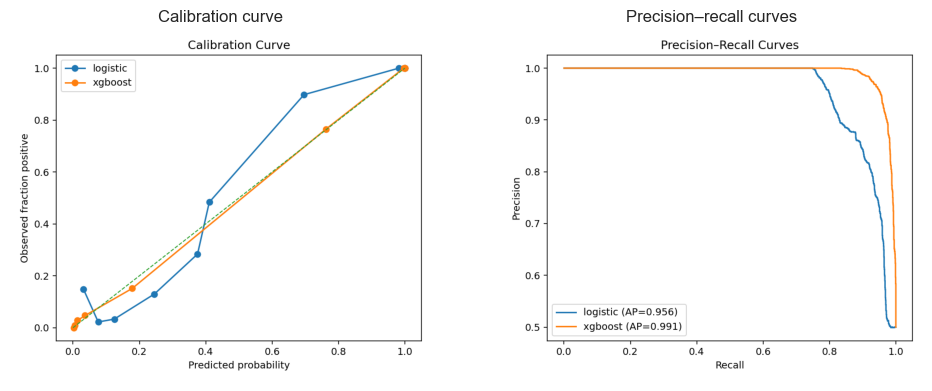

In [18]:
# plot calibration and precision-recall curves side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (fname, title) in zip(
    axes,
    [
        ("calibration.png", "Calibration curve"),
        ("pr_curves.png", "Precision–recall curves"),
    ]
):
    img = Image.open(PLOTS_DIR / fname)
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

**Interpretation:**

- XGBoost stays closer to the diagonal on the calibration curve, so its probabilities are better aligned with observed confirmation rates.  
- On the precision–recall plot, XGBoost keeps higher precision at most recall levels, which is helpful when prioritizing likely confirmations from many candidates.

XGBoost achieves higher precision at almost all recall levels, which is useful when prioritizing likely confirmations from many candidates.


## 4. Feature importance

Permutation importance helps show which physical and observational parameters drive the model predictions.

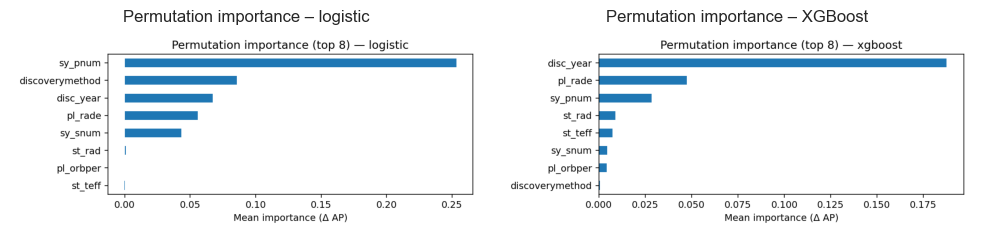

In [19]:
# plot permutation importance side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (fname, title) in zip(
    axes,
    [
        ("perm_importance_logistic.png", "Permutation importance – logistic"),
        ("perm_importance_xgboost.png", "Permutation importance – XGBoost"),
    ]
):
    img = Image.open(PLOTS_DIR / fname)
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

**Typical patterns:**

- Orbital and stellar parameters such as orbital period, planet radius, host star temperature, and discovery year carry most of the signal.  
- Discovery method and system multiplicity provide useful context but are secondary.  

Together, these features align with the EDA story and confirm that the model is using physically meaningful signals.

## 5. Example: scoring a candidate

This section reloads the trained XGBoost model, selects a single candidate from the sample table, and computes the probability that it is a confirmed exoplanet.

In [20]:
# view feature list from the training config
with (CONFIGS_DIR / "train.yaml").open("r") as f:
    cfg = yaml.safe_load(f)

cfg["features"]["include"]

['pl_orbper',
 'pl_rade',
 'st_teff',
 'st_rad',
 'sy_snum',
 'sy_pnum',
 'disc_year',
 'discoverymethod']

In [21]:
# feature columns used by the model
feature_cols = cfg["features"]["include"]

# load trained model
model_path = MODELS_DIR / "model_xgboost.joblib"
model = joblib.load(model_path)

# sample row from the processed table
sample_path = DATA_DIR / "raw" / "pscomppars_sample.csv"
df_sample = pd.read_csv(sample_path)

X_sample = df_sample[feature_cols].iloc[[0]]

# predict confirmation probability
proba = model.predict_proba(X_sample)[0, 1]

# show candidate info and prediction
display(df_sample.iloc[[0]][["pl_name"] + feature_cols].T.head(10))
print("Predicted confirmation probability:", round(proba, 3))

,0
pl_name,3204.01
pl_orbper,4.044654
pl_rade,2.44
st_teff,5172.7
st_rad,0.95
sy_snum,1.0
sy_pnum,1.0
disc_year,2016.0
discoverymethod,Transit


Predicted confirmation probability: 0.069


## 6. Takeaways

- XGBoost is the preferred model, with higher ROC-AUC and F1 and better calibration than logistic regression.  
- Feature importance aligns with the EDA story, highlighting orbital period, planet radius, and host star properties.  
- The notebook provides a simple pattern for loading saved artifacts and scoring new exoplanet candidates.